In [1]:
"""
Notebook to calculate analyse relationship between running and stimulus.
"""
import os

import numpy as np
import pickle
import h5py
import pandas
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline  

import sync_util
import exp_stim

/home/colleen/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# session to run
file_name = 'data/ophys_session_719034388/719034388_389886_20180712'

In [3]:
exp = exp_stim.Experiment(file_name) # can be long, particularly if running stimulus alignment

exp.extract_stim_run_info() # extracts info required to analyse stim-run

stimulus alignment pickle already exists.


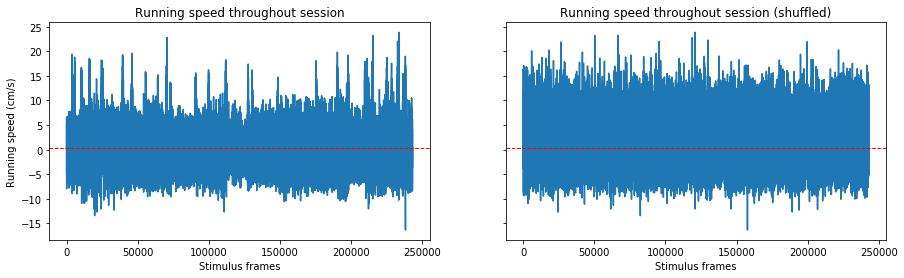

In [6]:
# plot running across all blocks
fig1a, ax1a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax1a[0].plot(exp.run_array)
ax1a[0].set_title('Running speed throughout session')
ax1a[0].set_ylabel('Running speed (cm/s)')
ax1a[0].set_xlabel('Stimulus frames')
ax1a[0].axhline(y=np.mean(exp.run_array), ls='dashed', c='r', lw='1')

temp_rand = exp.run_array.copy()
np.random.shuffle(temp_rand)
ax1a[1].plot(temp_rand)
ax1a[1].set_title('Running speed throughout session (shuffled)')
ax1a[1].set_xlabel('Stimulus frames')
ax1a[1].axhline(y=np.mean(temp_rand), ls='dashed', c='r', lw='1')

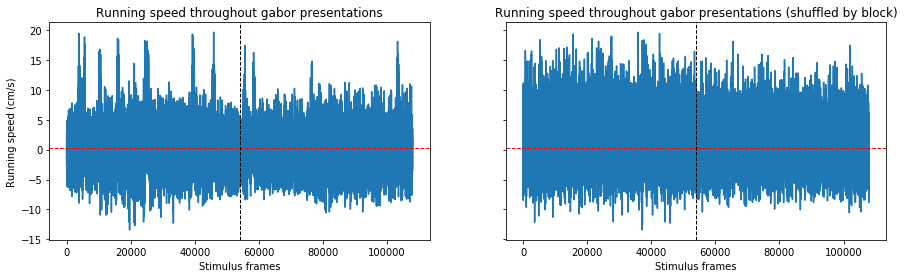

In [7]:
# plot running across gabor blocks
gab_run_rand = []
gab_run_breaks = []
temp_br = 0
for i in range(len(exp.gabors.run)):
    temp = exp.gabors.run[i].copy()
    np.random.shuffle(temp)
    gab_run_rand.extend([temp])
    # keep track of block breaks
    temp_br += exp.gabors.run[i].shape[0]
    gab_run_breaks.extend([temp_br])

# unite
gab_run_all = np.concatenate(exp.gabors.run)
gab_run_rand_all = np.concatenate(gab_run_rand)

# plot
fig2a, ax2a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax2a[0].plot(gab_run_all)
ax2a[0].set_title('Running speed throughout gabor presentations')
ax2a[0].set_ylabel('Running speed (cm/s)')
ax2a[0].set_xlabel('Stimulus frames')
ax2a[0].axhline(y=np.mean(gab_run_all), ls='dashed', c='r', lw='1')
for i in range(len(gab_run_breaks)-1):
    ax2a[0].axvline(x=gab_run_breaks[i], ls='dashed', c='k', lw='1')

ax2a[1].plot(gab_run_rand_all)
ax2a[1].set_title('Running speed throughout gabor presentations (shuffled by block)')
ax2a[1].set_xlabel('Stimulus frames')
ax2a[1].axhline(y=np.mean(gab_run_rand_all), ls='dashed', c='r', lw='1')
for i in range(len(gab_run_breaks)-1):
    ax2a[1].axvline(x=gab_run_breaks[i], ls='dashed', c='k', lw='1')

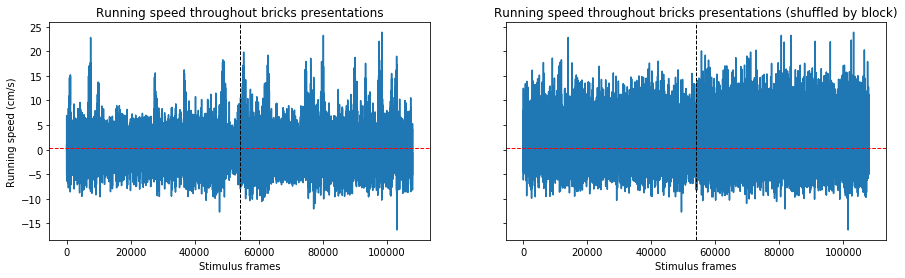

In [8]:
# plot running across brick blocks
bri_run_rand = []
bri_run_breaks = []
temp_br = 0
for i in range(len(exp.bricks.run)):
    temp = exp.bricks.run[i].copy()
    np.random.shuffle(temp)
    bri_run_rand.extend([temp])
    # keep track of block breaks
    temp_br += exp.bricks.run[i].shape[0]
    bri_run_breaks.extend([temp_br])

# unite
bri_run_all = np.concatenate(exp.bricks.run)
bri_run_rand_all = np.concatenate(bri_run_rand)

# plot
fig2c, ax2c = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax2c[0].plot(bri_run_all)
ax2c[0].set_title('Running speed throughout bricks presentations')
ax2c[0].set_ylabel('Running speed (cm/s)')
ax2c[0].set_xlabel('Stimulus frames')
ax2c[0].axhline(y=np.mean(bri_run_all), ls='dashed', c='r', lw='1')
for i in range(len(bri_run_breaks)-1):
    ax2c[0].axvline(x=bri_run_breaks[i], ls='dashed', c='k', lw='1')

ax2c[1].plot(bri_run_rand_all)
ax2c[1].set_title('Running speed throughout bricks presentations (shuffled by block)')
ax2c[1].set_xlabel('Stimulus frames')
ax2c[1].axhline(y=np.mean(bri_run_rand_all), ls='dashed', c='r', lw='1')
for i in range(len(bri_run_breaks)-1):
    ax2c[1].axvline(x=bri_run_breaks[i], ls='dashed', c='k', lw='1')

In [9]:
# plot average running for each 1.5 s subblock (ABCD/E): 300 ms before 0 to 1200 ms after
ran = [-exp.gabors.pre, exp.gabors.post]
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
gab_pre = [x + pre for x in exp.gabors.A_frame_n]
gab_post = [x + post for x in exp.gabors.A_frame_n]
gab_ind = zip(gab_pre, gab_post)

# get running values (use general run array, as A_frame_n are for full array)   
temp = [exp.run_array[x[0]:x[1]] for x in gab_ind]
# create a shuffled version (need to do both axes separately)
temp2 = np.asarray(temp[:])
np.random.shuffle(temp2)
np.random.shuffle(temp2.T)
temp2 = temp2.tolist()

gab_run_subbl = np.empty([len(temp), len(temp[0])])
gab_run_subbl_rand = np.empty_like(gab_run_subbl)
for i in range(len(temp)):
    if len(temp[i]) == len(temp[0]):
        gab_run_subbl[i] = np.asarray(temp[i])
        gab_run_subbl_rand[i] = np.asarray(temp2[i])
    # truncate the array in this case
    else:
        gab_run_subbl = gab_run_subbl[:i]
        gab_run_subbl_rand = gab_run_subbl_rand[:i]

# gather stats
gab_run_subbl_av = np.mean(gab_run_subbl, axis=0)
gab_run_subbl_rand_av = np.mean(gab_run_subbl_rand, axis=0)
gab_run_subbl_std = np.std(gab_run_subbl, axis=0)
gab_run_subbl_rand_std = np.std(gab_run_subbl_rand, axis=0)

Text(0.5,0,'Time (s)')

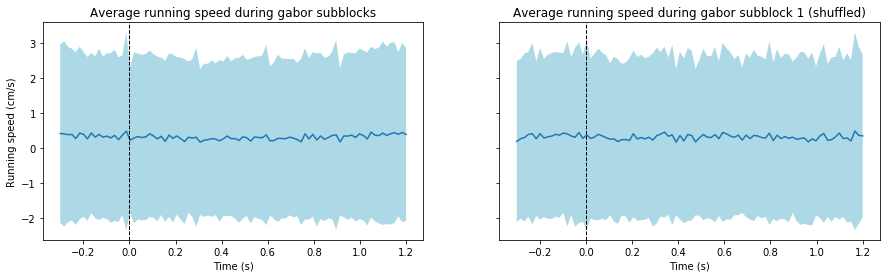

In [10]:
# plot
fig3a, ax3a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax3a[0].plot(x_ran_av, gab_run_subbl_av)
ax3a[0].fill_between(x_ran_av,  gab_run_subbl_av - gab_run_subbl_std,  gab_run_subbl_av + gab_run_subbl_std, facecolor='lightblue')
ax3a[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax3a[0].set_title('Average running speed during gabor subblocks')
ax3a[0].set_ylabel('Running speed (cm/s)')
ax3a[0].set_xlabel('Time (s)')

ax3a[1].plot(x_ran_av, gab_run_subbl_rand_av)
ax3a[1].fill_between(x_ran_av,  gab_run_subbl_rand_av - gab_run_subbl_rand_std,  gab_run_subbl_rand_av + gab_run_subbl_rand_std, 
                  facecolor='lightblue')
ax3a[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax3a[1].set_title('Average running speed during gabor subblock 1 (shuffled)')
ax3a[1].set_xlabel('Time (s)')

In [11]:
# get autocorrelation, snips around desired lag
lag_s = 3 # in sec
lag_f = int(exp.stim_fps * lag_s)

gab_autocorr_snips = []
gab_autocorr_rand_snips = []
for i in range(exp.gabors.n_blocks):
       
    # remove the mean of the values
    norm_values = exp.gabors.run[i] - np.mean(exp.gabors.run[i])
    # get autocorrelation snip
    autocorr = np.correlate(norm_values, norm_values, 'full')
    
    mid = int((autocorr.shape[0]-1)/2) # autocorr will always produce an odd length, so this should always give an integer
    autocorr_snip = autocorr[mid-lag_f:mid+lag_f]
    
    # deep copy normalized values and randomize
    norm_rand_values = norm_values[:]
    np.random.shuffle(norm_rand_values)
    autocorr_snip_rand = np.correlate(norm_rand_values, norm_rand_values, 'full')[mid-lag_f:mid+lag_f]
    
    # record normalized, snipped autocorrelations
    gab_autocorr_snips.append((autocorr_snip/np.max(autocorr_snip)).tolist())
    gab_autocorr_rand_snips.append((autocorr_snip_rand/np.max(autocorr_snip_rand)).tolist())

# average autocorrelations for each lag across blocks
gab_autocorr_mean = [float(sum(col))/len(col) for col in zip(*gab_autocorr_snips)]
gab_autocorr_rand_mean = [float(sum(col))/len(col) for col in zip(*gab_autocorr_rand_snips)]
    
x_auto_ran = np.linspace(-lag_s, lag_s, 2*lag_f)

Text(0.5,1,'Autocorrelation from -3 to 3 sec for gabors')

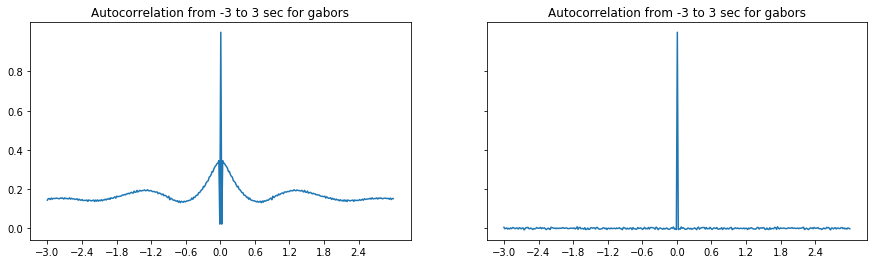

In [12]:
fig4a, ax4a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax4a[0].plot(x_auto_ran, gab_autocorr_mean)
ax4a[0].set_xticks(np.arange(-lag_s, lag_s, 0.6))
ax4a[0].set_yticks(np.arange(0, 1, 0.2))
ax4a[0].set_title('Autocorrelation from -3 to 3 sec for gabors')

ax4a[1].plot(x_auto_ran, gab_autocorr_rand_mean)
ax4a[1].set_xticks(np.arange(-lag_s, lag_s, 0.6))
ax4a[1].set_yticks(np.arange(0, 1, 0.2))
ax4a[1].set_title('Autocorrelation from -3 to 3 sec for gabors')

In [13]:
# Average running speed during 2-3 sec incl and following surprise vs no surprise

# gabors
ran = [-exp.gabors.surp_min_s, exp.gabors.surp_min_s+3] # adding extra time after
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

gab_x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
gab_pre_surp = [x + pre for x in exp.gabors.first_surp_frame_n]
gab_post_surp = [x + post for x in exp.gabors.first_surp_frame_n]
gab_ind_surp = zip(gab_pre_surp, gab_post_surp)

gab_pre_nosurp = [x + pre for x in exp.gabors.first_nosurp_frame_n[1:]] #excluding first occurrence
gab_post_nosurp = [x + post for x in exp.gabors.first_nosurp_frame_n[1:]]
gab_ind_nosurp = zip(gab_pre_nosurp, gab_post_nosurp)

# get running values (use general run array, as A_frame_n are for full array)   
temp_surp = [exp.run_array[x[0]:x[1]] for x in gab_ind_surp]
temp_nosurp =  [exp.run_array[x[0]:x[1]] for x in gab_ind_nosurp]

gab_run_subbl_surp = np.empty([len(temp_surp), len(temp_surp[0])])
gab_run_subbl_nosurp = np.empty([len(temp_nosurp), len(temp_nosurp[0])])
for i in range(len(temp_surp)):
    if len(temp_surp[i]) == len(temp_surp[0]):
        gab_run_subbl_surp[i] = np.asarray(temp_surp[i])
    # truncate the array in this case
    else:
        gab_run_subbl_surp = gab_run_subbl_surp[:i]
        
for i in range(len(temp_nosurp)):
    if len(temp_nosurp[i]) == len(temp_nosurp[0]):
        gab_run_subbl_nosurp[i] = np.asarray(temp_nosurp[i])
    # truncate the array in this case
    else:
        gab_run_subbl_nosurp = gab_run_subbl_nosurp[:i]

# gather stats
gab_run_subbl_surp_av = np.mean(gab_run_subbl_surp, axis=0)
gab_run_subbl_nosurp_av = np.mean(gab_run_subbl_nosurp, axis=0)
gab_run_subbl_surp_std = np.std(gab_run_subbl_surp, axis=0)
gab_run_subbl_nosurp_std = np.std(gab_run_subbl_nosurp, axis=0)


# bricks
ran = [-exp.bricks.surp_min_s, exp.bricks.surp_min_s+3]
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

bri_x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
bri_pre_surp = [x + pre for x in exp.bricks.first_surp_frame_n]
bri_post_surp = [x + post for x in exp.bricks.first_surp_frame_n]
bri_ind_surp = zip(bri_pre_surp, bri_post_surp)

bri_pre_nosurp = [x + pre for x in exp.bricks.first_nosurp_frame_n[1:]]
bri_post_nosurp = [x + post for x in exp.bricks.first_nosurp_frame_n[1:]]
bri_ind_nosurp = zip(bri_pre_nosurp, bri_post_nosurp)

# get running values (use general run array, as A_frame_n are for full array)   
temp_surp = [exp.run_array[x[0]:x[1]] for x in bri_ind_surp]
temp_nosurp =  [exp.run_array[x[0]:x[1]] for x in bri_ind_nosurp]

bri_run_subbl_surp = np.empty([len(temp_surp), len(temp_surp[0])])
bri_run_subbl_nosurp = np.empty([len(temp_nosurp), len(temp_nosurp[0])])
for i in range(len(temp_surp)):
    if len(temp_surp[i]) == len(temp_surp[0]):
        bri_run_subbl_surp[i] = np.asarray(temp_surp[i])
    # truncate the array in this case
    else:
        bri_run_subbl_surp = bri_run_subbl_surp[:i]
        
for i in range(len(temp_nosurp)):
    if len(temp_nosurp[i]) == len(temp_nosurp[0]):
        bri_run_subbl_nosurp[i] = np.asarray(temp_nosurp[i])
    # truncate the array in this case
    else:
        bri_run_subbl_nosurp = bri_run_subbl_nosurp[:i]

# gather stats
bri_run_subbl_surp_av = np.mean(bri_run_subbl_surp, axis=0)
bri_run_subbl_nosurp_av = np.mean(bri_run_subbl_nosurp, axis=0)
bri_run_subbl_surp_std = np.std(bri_run_subbl_surp, axis=0)
bri_run_subbl_nosurp_std = np.std(bri_run_subbl_nosurp, axis=0)

Text(0.5,0,'Time (s)')

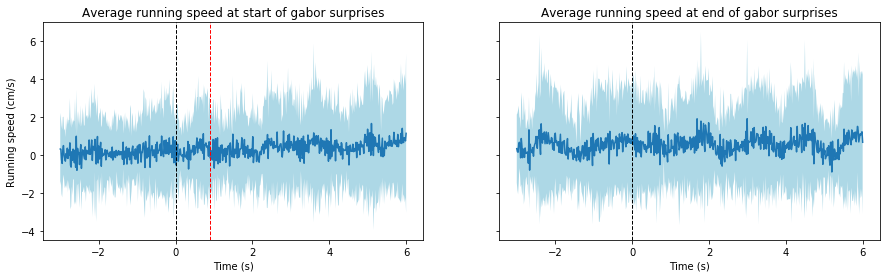

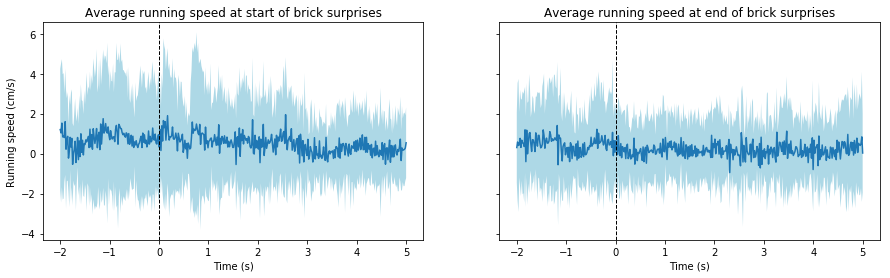

In [14]:
# plot
fig5a, ax5a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax5a[0].plot(gab_x_ran_av, gab_run_subbl_surp_av)
ax5a[0].fill_between(gab_x_ran_av, gab_run_subbl_surp_av - gab_run_subbl_surp_std,  gab_run_subbl_surp_av + gab_run_subbl_surp_std, facecolor='lightblue')
ax5a[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax5a[0].axvline(x=0.9, ls='dashed', c='r', lw='1')
ax5a[0].set_title('Average running speed at start of gabor surprises')
ax5a[0].set_ylabel('Running speed (cm/s)')
ax5a[0].set_xlabel('Time (s)')

ax5a[1].plot(gab_x_ran_av, gab_run_subbl_nosurp_av)
ax5a[1].fill_between(gab_x_ran_av, gab_run_subbl_nosurp_av - gab_run_subbl_nosurp_std,  gab_run_subbl_nosurp_av + gab_run_subbl_nosurp_std, facecolor='lightblue')
ax5a[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax5a[1].set_title('Average running speed at end of gabor surprises')
ax5a[1].set_xlabel('Time (s)')

fig5c, ax5c = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax5c[0].plot(bri_x_ran_av, bri_run_subbl_surp_av)
ax5c[0].fill_between(bri_x_ran_av, bri_run_subbl_surp_av - bri_run_subbl_surp_std,  bri_run_subbl_surp_av + bri_run_subbl_surp_std, facecolor='lightblue')
ax5c[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax5c[0].set_title('Average running speed at start of brick surprises')
ax5c[0].set_ylabel('Running speed (cm/s)')
ax5c[0].set_xlabel('Time (s)')

ax5c[1].plot(bri_x_ran_av, bri_run_subbl_nosurp_av)
ax5c[1].fill_between(bri_x_ran_av, bri_run_subbl_nosurp_av - bri_run_subbl_nosurp_std,  bri_run_subbl_nosurp_av + bri_run_subbl_nosurp_std, facecolor='lightblue')
ax5c[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax5c[1].set_title('Average running speed at end of brick surprises')
ax5c[1].set_xlabel('Time (s)')

Text(0.5,1,'Statistics of running speed during bricks no surprise vs surprise')

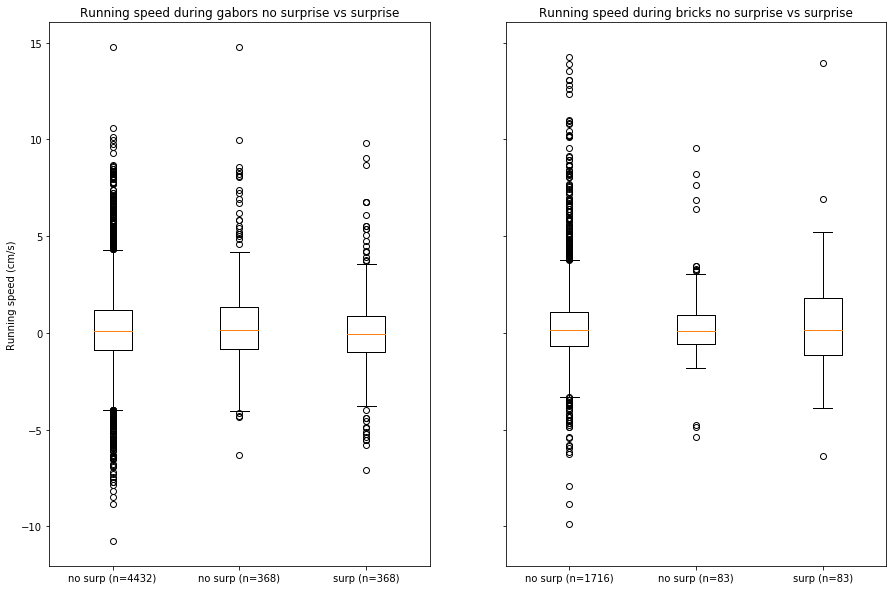

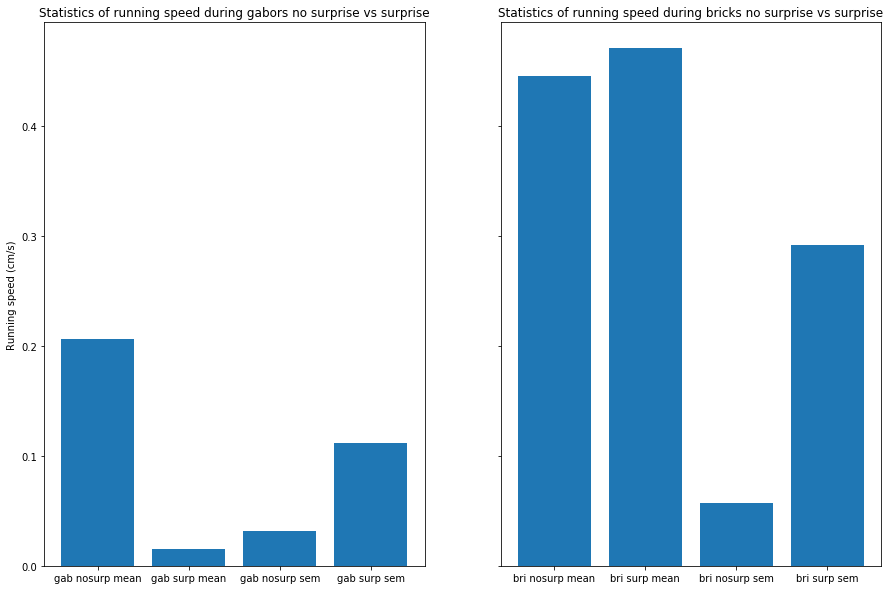

In [15]:
# Boxplot of surprise vs no surprise (bricks, gabors)
gab_nosurp_n = len(exp.gabors.nosurp_frame_n)
gab_surp_n = len(exp.gabors.surp_frame_n)
# get a random subset to plot
gab_nosurp_rand = exp.run_array[exp.gabors.nosurp_frame_n][:]

fig6, ax6 = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax6[0].boxplot([exp.run_array[exp.gabors.nosurp_frame_n], gab_nosurp_rand[:gab_surp_n], exp.run_array[exp.gabors.surp_frame_n]])
ax6[0].set_title('Running speed during gabors no surprise vs surprise')
ax6[0].set_ylabel('Running speed (cm/s)')
ax6[0].set_xticklabels(['no surp (n={})'.format(gab_nosurp_n), 'no surp (n={})'.format(gab_surp_n), 'surp (n={})'.format(gab_surp_n)])

bri_nosurp_n = len(exp.bricks.nosurp_frame_n)
bri_surp_n = len(exp.bricks.surp_frame_n)
# get a random subset to plot
bri_nosurp_rand = exp.run_array[exp.bricks.nosurp_frame_n][:]
ax6[1].boxplot([exp.run_array[exp.bricks.nosurp_frame_n], bri_nosurp_rand[:bri_surp_n], exp.run_array[exp.bricks.surp_frame_n]])
ax6[1].set_title('Running speed during bricks no surprise vs surprise')
ax6[1].set_xticklabels(['no surp (n={})'.format(bri_nosurp_n), 'no surp (n={})'.format(bri_surp_n), 'surp (n={})'.format(bri_surp_n)])

# bar plots of statistics
fig7, ax7 = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax7[0].bar(['gab nosurp mean', 'gab surp mean', 'gab nosurp sem', 'gab surp sem'], [np.mean(exp.run_array[exp.gabors.nosurp_frame_n]), np.mean(exp.run_array[exp.gabors.surp_frame_n]),
            scipy.stats.sem(exp.run_array[exp.gabors.nosurp_frame_n]), scipy.stats.sem(exp.run_array[exp.gabors.surp_frame_n])])
ax7[0].set_title('Statistics of running speed during gabors no surprise vs surprise')
ax7[0].set_ylabel('Running speed (cm/s)')

ax7[1].bar(['bri nosurp mean', 'bri surp mean', 'bri nosurp sem', 'bri surp sem'], [np.mean(exp.run_array[exp.bricks.nosurp_frame_n]), np.mean(exp.run_array[exp.bricks.surp_frame_n]),
            scipy.stats.sem(exp.run_array[exp.bricks.nosurp_frame_n]), scipy.stats.sem(exp.run_array[exp.bricks.surp_frame_n])])
ax7[1].set_title('Statistics of running speed during bricks no surprise vs surprise')

Text(0,0.5,'Running speed (cm/s)')

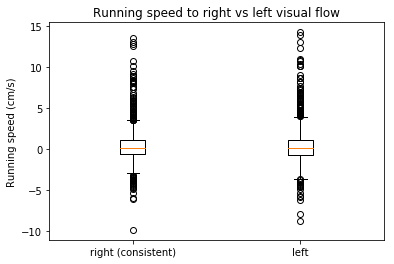

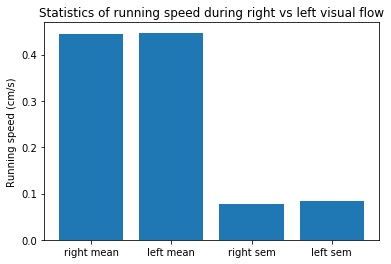

In [16]:
# Average and std of running when bricks fit with flow vs reverse (no surprise segs)
fig8, ax8 = plt.subplots()
ax8.boxplot([exp.run_array[exp.bricks.right_frame_n], exp.run_array[exp.bricks.left_frame_n]])
ax8.set_title('Running speed to right vs left visual flow')
ax8.set_ylabel('Running speed (cm/s)')
ax8.set_xticklabels(['right (consistent)', 'left'])

# bar plots of statistics
fig9, ax9 = plt.subplots()
ax9.bar(['right mean', 'left mean', 'right sem', 'left sem'], [np.mean(exp.run_array[exp.bricks.right_frame_n]), np.mean(exp.run_array[exp.bricks.left_frame_n]),
            scipy.stats.sem(exp.run_array[exp.bricks.right_frame_n]), scipy.stats.sem(exp.run_array[exp.bricks.left_frame_n])])
ax9.set_title('Statistics of running speed during right vs left visual flow')
ax9.set_ylabel('Running speed (cm/s)')

Text(17.2,0.5,'Running speed (cm/s)')

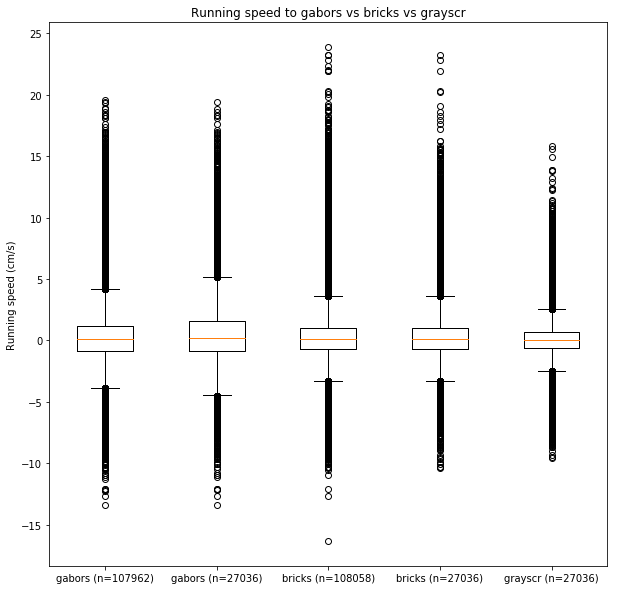

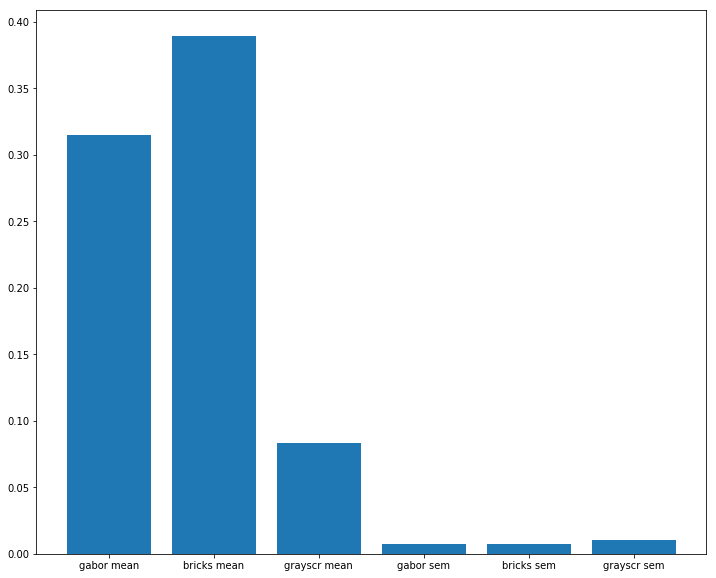

In [17]:
# Average and std running to gray (>1s) vs gabors vs bricks (incl surprise segs)
gab_run = []
[gab_run.extend(x) for x in exp.gabors.run]
bri_run = []
[bri_run.extend(x) for x in exp.bricks.run]
grayscr_run = []
[grayscr_run.extend(x) for x in exp.grayscr.run_excl]

gab_run_n = len(gab_run)
bri_run_n = len(bri_run)
grayscr_run_n = len(grayscr_run)

# shuffle
gab_run_rand = gab_run[:]
bri_run_rand = bri_run[:]
np.random.shuffle(gab_run_rand)
np.random.shuffle(bri_run_rand)

fig10, ax10 = plt.subplots(figsize=(10, 10))
ax10.boxplot([gab_run, gab_run[:grayscr_run_n], bri_run, bri_run_rand[:grayscr_run_n], 
              grayscr_run])
ax10.set_title('Running speed to gabors vs bricks vs grayscr')
ax10.set_ylabel('Running speed (cm/s)')
ax10.set_xticklabels(['gabors (n={})'.format(gab_run_n), 'gabors (n={})'.format(grayscr_run_n), 
                     'bricks (n={})'.format(bri_run_n), 'bricks (n={})'.format(grayscr_run_n),
                     'grayscr (n={})'.format(grayscr_run_n)])

# bar plots of statistics
fig11, ax11 = plt.subplots(figsize=(12, 10))
ax11.bar(['gabor mean', 'bricks mean', 'grayscr mean', 'gabor sem', 'bricks sem', 'grayscr sem'], 
         [np.mean(gab_run), np.mean(bri_run), np.mean(grayscr_run), 
          scipy.stats.sem(gab_run), scipy.stats.sem(bri_run), scipy.stats.sem(grayscr_run)])
ax9.set_title('Statistics of running speed during right vs left visual flow')
ax9.set_ylabel('Running speed (cm/s)')

